In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from math import log2


# Load and Clean Data
df = pd.read_csv("sleep_health.csv").dropna()

df_2015 = pd.DataFrame({
    "Poor_Sleep": df["2015NRS"],
    "Gender": df["gender"],
    "Age": df["2015Age"],
    "BMI": df["2015BMI"],
    "Smoking": df["2015Smoking"],
    "Exercise": df["2015EX"],
    "Diabetes": df["2015Diabetes"],
    "Drinking_Habit": df["2015DrinkHabit"],
    "Hypertension": df["2015Hypertension"]
})

# Bin Age and BMI
df_2015["Age"] = pd.cut(df_2015["Age"], bins=[39, 49, 59, 69, 74], labels=["40–49", "50–59", "60–69", "70–74"])
df_2015["BMI"] = pd.cut(df_2015["BMI"], bins=[0, 18.5, 25, float("inf")], labels=["Underweight", "Normal", "Overweight"])

# Encode all features
le = LabelEncoder()
for col in df_2015.columns:
    df_2015[col] = le.fit_transform(df_2015[col])

# Train
target = "Poor_Sleep"
features = [col for col in df_2015.columns if col != target]
X = df_2015[features]
y = df_2015[target]

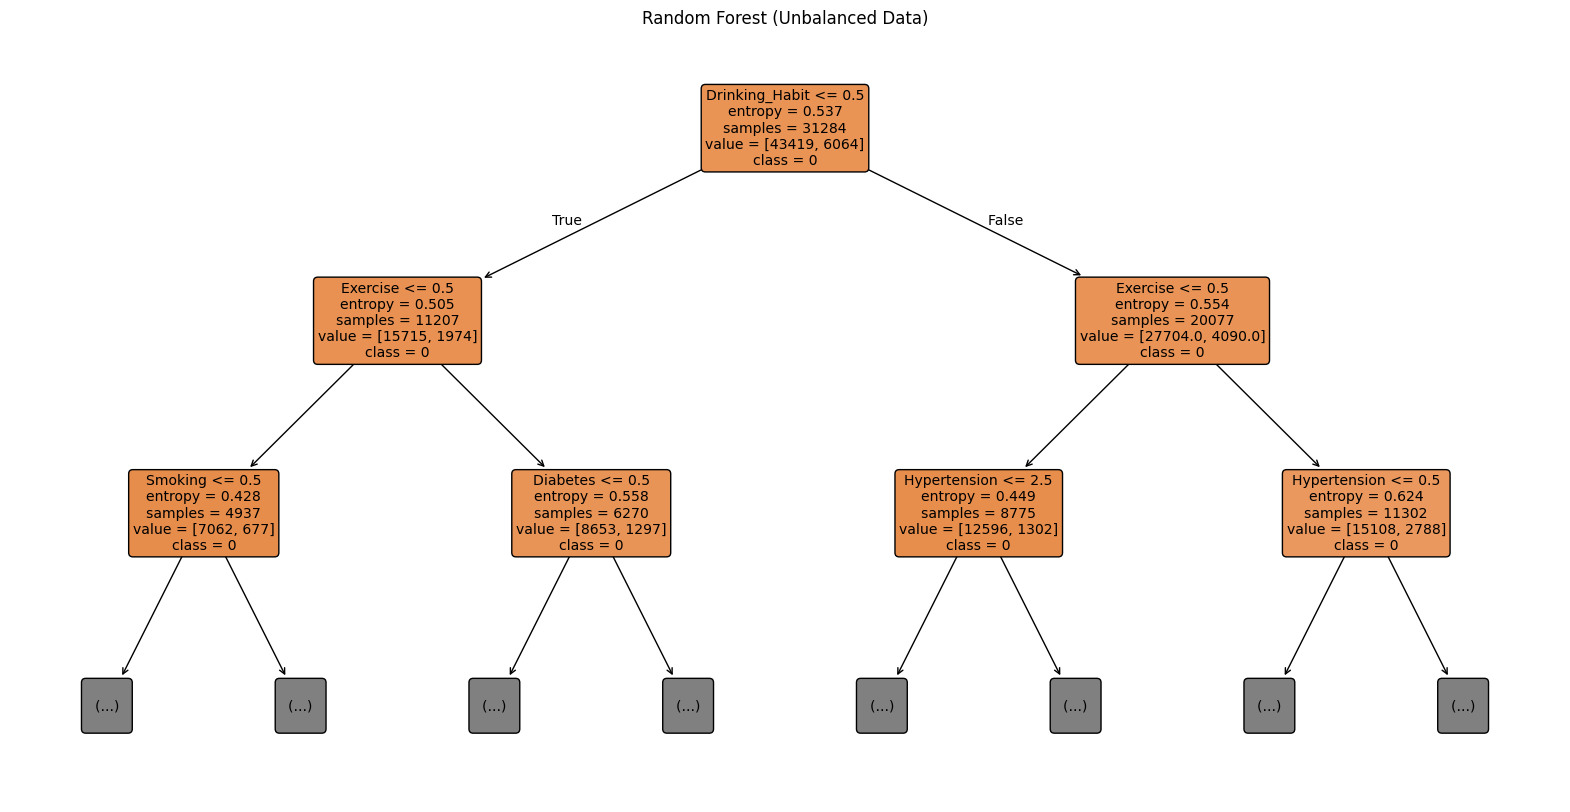

In [30]:
# Create RandomForestClassifier
unbalanced_forest = RandomForestClassifier(criterion="entropy", random_state=42, max_depth=8)
unbalanced_forest.fit(X, y)

# Plot Tree
plt.figure(figsize=(20, 10))
plot_tree(unbalanced_forest.estimators_[0], 
          feature_names=X.columns, 
          class_names=[str(cls) for cls in unbalanced_forest.classes_],
          filled=True, 
          rounded=True,
          max_depth=2)
plt.title("Random Forest (Unbalanced Data)")
plt.show()

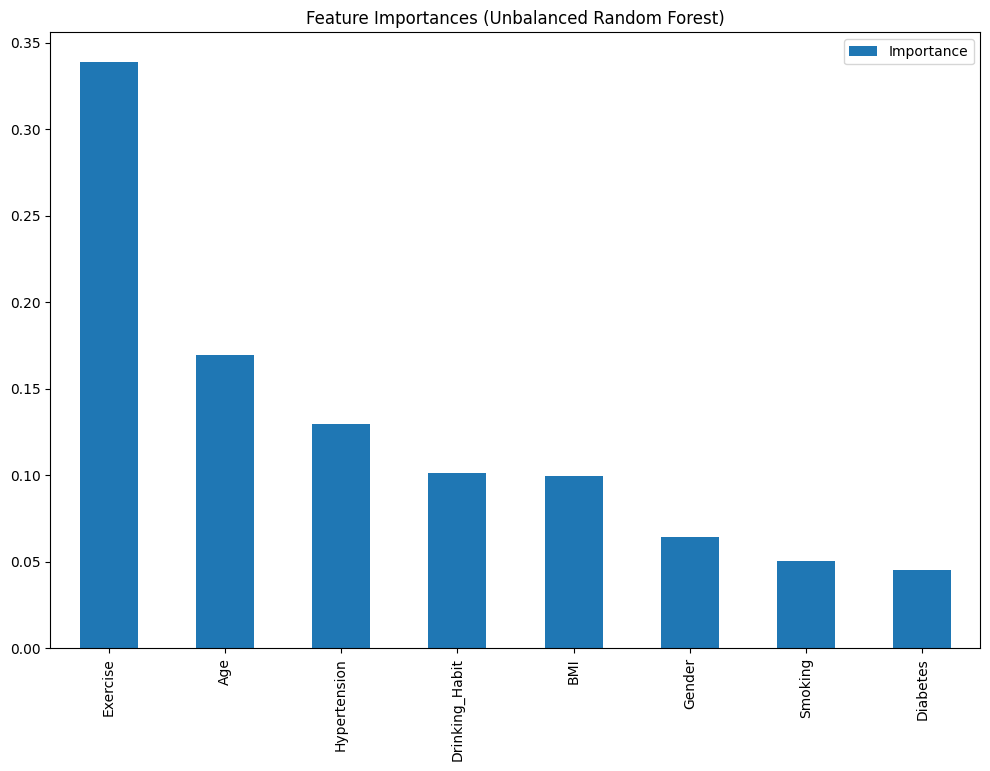

In [31]:
# Plot feature importance
unbalanced_FI = unbalanced_forest.feature_importances_ 

feat_importances = pd.DataFrame(unbalanced_FI, index=X.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances.plot(kind='bar', figsize=(12,8))
plt.title("Feature Importances (Unbalanced Random Forest)")
plt.show()

In [32]:
# Apply SMOTE to Balance Dataset
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X, y)

df_smote = pd.DataFrame(X_resampled, columns=features)
df_smote["Poor_Sleep"] = y_resampled

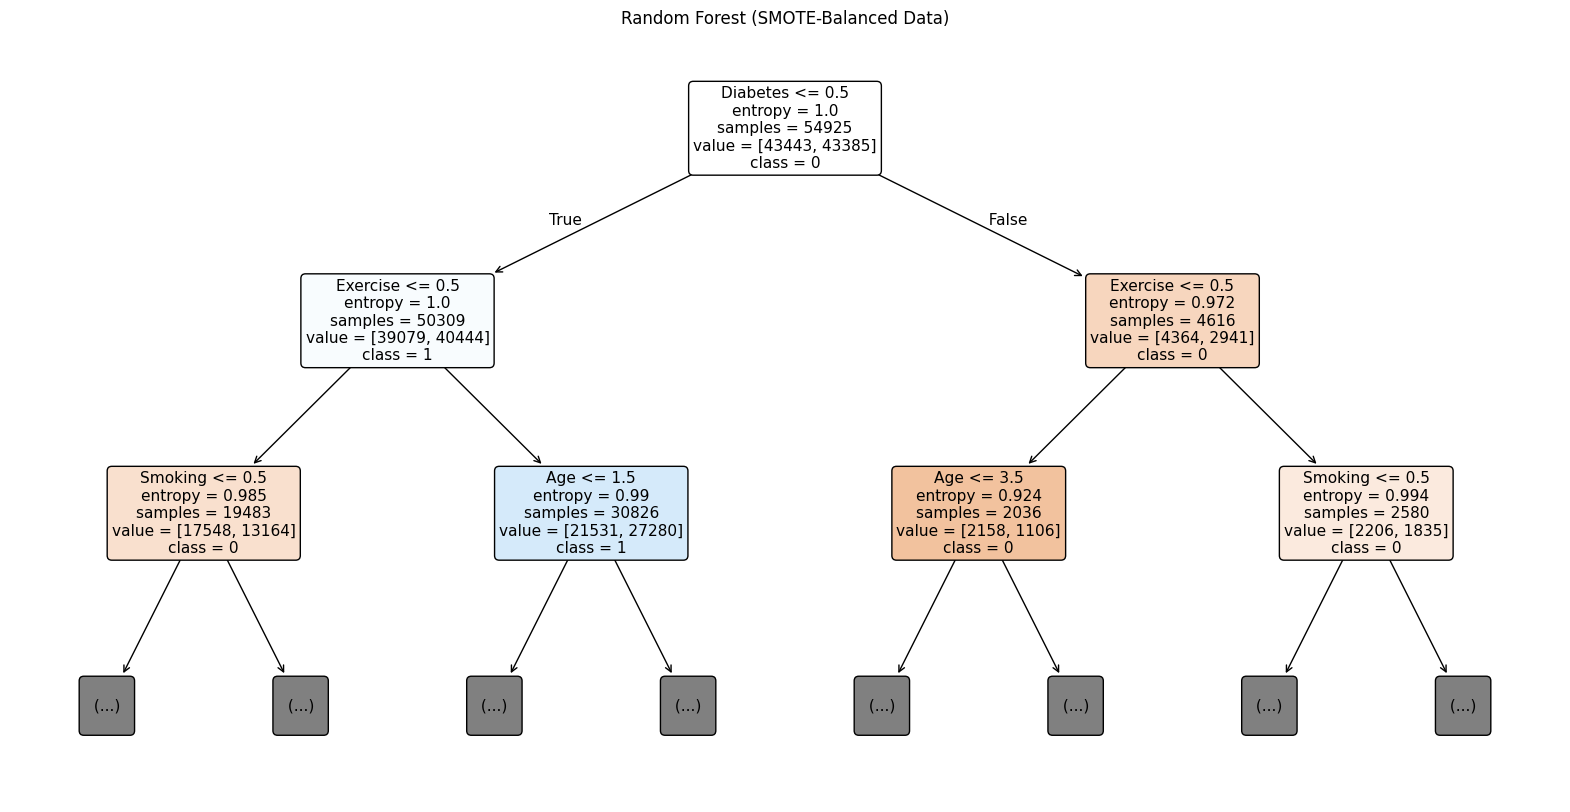

In [33]:
# Create RandomForestClassifier after SMOTE
balanced_forest = RandomForestClassifier(criterion="entropy", max_depth=8, random_state=42)
balanced_forest.fit(X_resampled, y_resampled)

# Plot Tree
plt.figure(figsize=(20, 10))
plot_tree(balanced_forest.estimators_[0], 
          feature_names=X.columns, 
          class_names=[str(cls) for cls in balanced_forest.classes_],
          filled=True, 
          rounded=True,
          max_depth=2)
plt.title("Random Forest (SMOTE-Balanced Data)")
plt.show()

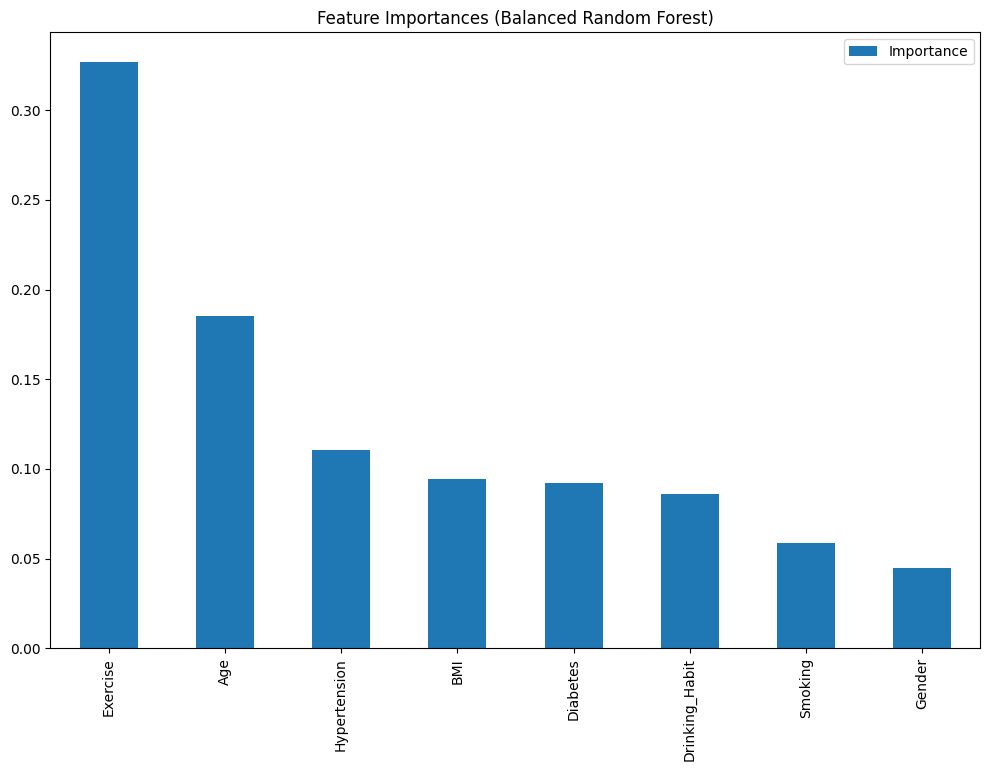

In [ ]:
# Plot feature importance
balanced_FI = balanced_forest.feature_importances_

feat_importances = pd.DataFrame(balanced_FI, index=X.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances.plot(kind='bar', figsize=(12,8))
plt.title("Feature Importances (Balanced Random Forest)")
plt.show()

In [42]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Apply SMOTE to training data
sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

# Train
balanced_forest = RandomForestClassifier(criterion="entropy", max_depth=8, random_state=42)
balanced_forest.fit(X_train_resampled, y_train_resampled)

# Evaluate on untouched data
y_pred = balanced_forest.predict(X_test)

# Metrics
print(f"Accuracy on Test Set: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Accuracy on Test Set: 0.5386

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.53      0.67      8683
           1       0.15      0.57      0.23      1214

    accuracy                           0.54      9897
   macro avg       0.52      0.55      0.45      9897
weighted avg       0.81      0.54      0.62      9897

